### 1) TO-DO

### 2.a) Transition matrix
The transition matrix is hand-calculated from the given dice.

In [89]:
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn

A = np.matrix([[0.25,    0,   0, 0.25, 0.25, 0.25], # side 1
               [0.25, 0.25,   0, 0.25, 0.25,    0],
               [0.25,    0,   0,  0.5, 0.25,    0],
               [0.25,    0, 0.5,    0, 0.25,    0],
               [0.25, 0.25,   0, 0.25, 0.25,    0],
               [0.25,    0,   0, 0.25, 0.25, 0.25]]).T

print(A)

[[ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.    0.25  0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.5   0.    0.  ]
 [ 0.25  0.25  0.5   0.    0.25  0.25]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.25  0.    0.    0.    0.    0.25]]


### 2.b) Stationary Distribution
We calculate the stationary distribution by calculating the right eigenvector corresponding to the eigenvalue of 1.

In [161]:
eva, evec = LA.eig(A)
i = np.argmax(np.isclose(eva, 1.0))
v = np.squeeze(np.asarray(evec[:,i]))
v = v / sum(v)
print('Stationary distribution for x in [1,6]:',v)

Stationary distribution for x in [1,6]: [ 0.25000000-0.j  0.08333333-0.j  0.11111111-0.j  0.22222222-0.j
  0.25000000-0.j  0.08333333-0.j]


Stationary distribution is not uniform.

### 2.c) Detailed balance condition
In order for detailed balance condition to hold, the $A\pi$ matrix must be symmetrical over the diagonal at t (same as saying $A_{ji}\pi_i = A_{ij}\pi_j$ must hold).

In [162]:
x = np.multiply(A, v)
np.isclose(x, x.T).all()

False

### 2.d) Calculating the mix time
We calculate $T_{mix}$ by looking at the total variation distance between $\pi$ and $A^t\pi_0$, continuing until the difference is smaller than $\epsilon = 10^{-8}$. Note that we use their logarithms so that the code is scalable for even smaller $\epsilon$.

In [92]:
def total_variation_distance(v1, v2):
    return np.sum(np.absolute(v1 - v2)) / 2

def mix_time(A, v_stationary, eps = float(1e-8)):
    t_mix = 0
    log_tvd = 0
    log_eps = np.log(float(1e-8))
    At = np.identity(len(A))
    while log_tvd > log_eps:
        t_mix += 1
        At = At * A
        log_tvd = np.log(total_variation_distance(At*A[:,0], v_stationary))
    return t_mix

v_t = np.matrix(v).T
t_mix = mix_time(A, v_t)
print('Mix time:',t_mix)

Mix time: 23


### 2.e) Verification of convergence
We visualize $A^t$ for $t = \{1,3,7, T_{mix}-1, T_{mix}\}$ to see its convergence.

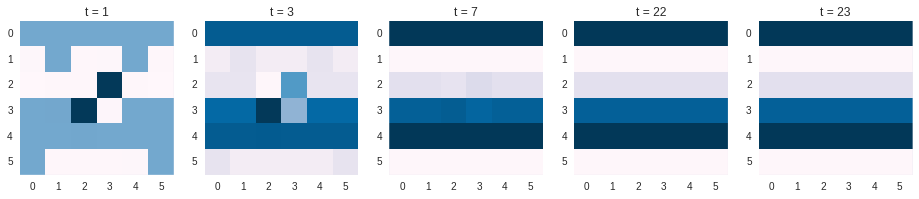

In [93]:
ts = [1,3,7,t_mix-1, t_mix]
f, subplot = plt.subplots(1,len(ts), figsize=(16,5))
for i in range(len(ts)):
    subplot[i].imshow(A ** ts[i], aspect = 'equal', interpolation='none', cmap = 'PuBu')
    subplot[i].set_title('t = '+str(ts[i]))
    subplot[i].grid(False)

We verify the mixing time by plotting $A^t\pi_0$ for $0\lt t\le T_{mix}$.

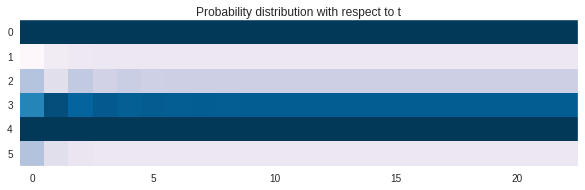

In [155]:
At = np.identity(len(A))

A_plt = np.zeros((len(A),t_mix))
for i in range(0,t_mix):
    At = At * A
    A_plt[:,i] = np.array((At * A[:,0]).T)[0]

f, subplot = plt.subplots(figsize=(10,10))
subplot.imshow(A_plt, aspect = 'equal', interpolation = 'none', cmap = 'PuBu')
subplot.set_title('Probability distribution with respect to t')
subplot.grid(False)

### 2.f) Independent samples
In order to generate completely independent samples from the desired distribution, we start the chain *N* times and get the $X^n_t$ where $t = T_{mix}$ for $0\lt n\le N$. We then plot the distribution of these samples at different *t*.

Distribution at t=T_mix: [ 0.23090909  0.089       0.109       0.21        0.273       0.065     ]


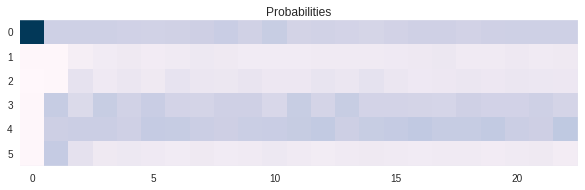

In [147]:
N = 1000
np.random.seed(N)
def sim_chain(A, i_end):
    chain = np.zeros(i_end, dtype = np.int)
    chain[0] = 1
    for i in range(1,i_end):
        pr = np.squeeze(np.asarray(A[:, chain[i-1]-1]))
        chain[i] = np.random.choice([1,2,3,4,5,6], p = pr)
    return chain
    
samples = np.zeros((N,t_mix), dtype = np.int)
for i in range(0, N):
    samples[i,:] = sim_chain(A, t_mix)

xx = np.apply_along_axis(lambda x: np.histogram(x, bins = [0,1.1,2.1,3.1,4.1,5.1,6.1], density = True)[0], 0, samples)
f, subplot = plt.subplots(figsize=(10,10))
subplot.imshow(xx, aspect = 'equal', interpolation = 'none', cmap = 'PuBu')
subplot.set_title('Probabilities')
subplot.grid(False)
print('Distribution at t=T_mix:',xx[:,-1])

The colors are easier to see when plotted starting from $t=2$ since the probability of $X_t=1$ is always 1, which is never again reached after $t=1$.

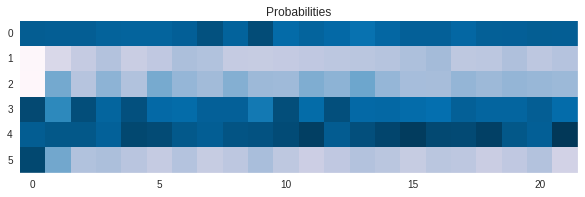

In [152]:
f, subplot = plt.subplots(figsize=(10,10))
subplot.imshow(xx[:,1:], aspect = 'equal', interpolation = 'none', cmap = 'PuBu')
subplot.set_title('Probabilities')
subplot.grid(False)

### 2.g) Single chain dependent samples
We simulate the chain for $T_{mix} + N$ steps, and discard the first $T_{mix}$ steps.

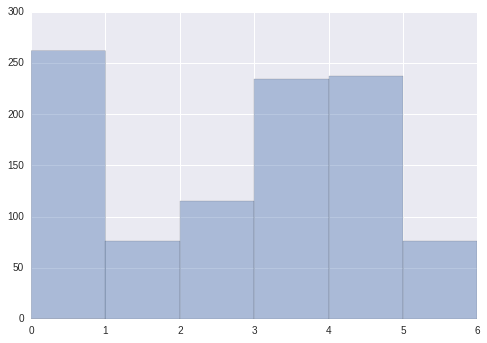

In [41]:
chain = sim_chain(A, t_mix+N)
nburnin = t_mix
seaborn.distplot(chain[nburnin:], kde = False, bins = [0,1,2,3,4,5,6])

To easily see whether this histogram agrees with the intended probability distribution, we calculate their total variation distance.

In [43]:
px = np.bincount(chain[nburnin:].astype(int))
px = px / np.sum(px)
print('Expected probabilities:',v)
print('Single chain probabilities:',px)
print('Total variation distance:',total_variation_distance(v,px))

Expected probabilities: [ 0.25000000-0.j  0.08333333-0.j  0.11111111-0.j  0.22222222-0.j
  0.25000000-0.j  0.08333333-0.j]
Single chain probabilities: [ 0.262  0.076  0.115  0.234  0.237  0.076]
Total variation distance: 0.0276666666667


We see that the variation between the expected probabilities and the dependent samples from a single chain is very low, and as such, it is a strong indication that these samples are coming from the same distribution.